# War and Peace: Modelling the Battle of 73 Easting

## Introduction 
    
On 26 February 1991 [10], the last large scale tank battle ever fought took place between the UN coalition forces against the Iraqi Armored Division as part of Operation Desert Sabre. The result was the decimation of the Iraqi forces, with them losing 160 tanks throughout the day compared to the UN forces losing none of their tanks even though the Iraqi forces had an overwhelming numerical advantage. If the Iraqi commanders could have modelled this battle before hand and foreseen this outcome, would they have chosen a different course of action?

Modelling and simulation thus play a huge role in the military domain and the United States even has a dedicated entity, the Modeling and Simulation Coordination Office, towards developing and implementing accurate simulations [3]. The benefits of a successful prediction cannot be understated, but its definitely not the sole benefit of a precise model. The use of a model facilitates the testing of hypothetical questions [12], the what-ifs that could possibly flip the narrative, without having to spend resources on physical war games. Some hypothetical can even be physically impossible to conduct without significant risk.

This tutorial hopes to emphasize these benefits and difficulties faced when applying the various models when applied to a military battle and this process will cover the development of the models in increasing granularity, increasing in complexity by incorporating additional factors with each subsequent model [11].


## Literature Review
Determining the outcome of a battle has always been the primary goal of a military simulation and a myriad of methods to so have been devised since the concept of tactics was introduced [5]. However, not all models are built the same and models developed earlier, when weaponry and technology was still in its infancy, tend to be much simpler as battles are usually dominated by one-on-one melee duels. Lanchester’s Laws, developed in 1916 [6], are a prime example of the school of thought of that era as the models developed from these times were simpler, with less factors being incorporated. Research done into applying such older models into modern battles often encounter large fitting errors, as in the modelling of the Battle
of Kursk [9]. The arrival of machines of war such as tanks and machine guns however, soon changed the face of war, leading to the development of more complex models. These models attempt to account for a larger amount of factors, from the quantitative features like weapons, to qualitative ones such as morale [13]. Ultimately, the complexity of modern warfare far outstrips the possibility of a precise model and a large stochastic element needs to be introduced to account for this variability. Models that are able to incorporate this variability, such as in a Markov chain [4], are thus better able to approximate a likely outcome. Agent based models take this step further as incorporating independent thought into the individual agents allows self-organizing behavior to be more evident without having to completely grasp the analysis of the full system of systems [1]. This can thus be seen as the gold standard of modern military gaming. Particularly for the Battle of 73 Easting, the most comprehensive simulation efforts was conducted by the Defense Advanced Research Projects Agency (DARPA) together with the Insitute for Defense Analyses (IDA) . Just 6 months after the conclusion of the battle, DARPA had fused terrain data with the force composition to produce a simulated recreation of the battle. This is akin to agent based model, with each agent following a programmed mission profile. However, given the state of technology in 1991, they were severely limited by the available memory for each simulation [11].

## Platform

We will be using Python as our development platform together with a few different libraries. Additional libraries requried by speicfic models will be included in their respective sections.

In [1475]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

## Problem Description

Operation Desert Sabre started on 24 February [15] and encompassed the entire coalition’s efforts in counterattacking Iraq by crossing the border from Kuwait. The Battle of 73 Easting, in particular, refers to a 45 minute block of the 3rd day of this operation when the 2nd Armored Calvary Regiment (Ghost, Eagle, and Iron troops) advanced from 70 Easting to 73 Easting at 1545H, meeting the Tawakalna 18th Mechanized Brigade and the 9th Armored Brigade "in the midst of a severe rain and sandstorm" [16]. 

### Assumptions
1. All armored units are homogeneous and have the same equipment as other tanks of the same model and do not vary over time.
2. Infantry fire is negligible due to their low numbers and low effectiveness against armored vehicles.
3. The theatre for the battle is limited to a small area between 70 and 73 Easting.
4. A hit is either a kill or not, with no in between, representing the fact that most shells either penetrate the armor and does destructive damage, or bounce off harmlessly.
    
### Aim
The aim of this tutorial is to simulate the Battle of 73 Easting under the above conditions by determining the parameters of each model. Each model will then be evaluated on
1. Accuracy compared to the actual battle
2. Ease of modifying the model to account for hypothetical situations

### Input and Output
<img src = "model2.jpg" style="width: 650px;">
<center> Figure 1. Conceptual Model</center><br />

Giving the context of the battle, the input of each model can be seen as the number, strength, and location of each tank. From these parameters, the model will then output the predicted number of casualties on both sides. Each model in this tutorial will use the same parameters to ensure that comparison amongst them is fair. However, not all parameters are required depending on the model

For the Battle of 73 Easting, the number of units and strength of each unit is given in these cells. These are historical data [16][18] that have been tested for outside the battlefield, and are akin to what commanders will have before an actual battle.

In [1476]:
# M1A1 Parameters

M1A1_N = 28 # Number of M1A1 Tanks
M1A1_V = 48 # Velocity in kmph
M1A1_HIT = 0.78 # Probability of hitting a T-62 Tank at 1000m
M1A1_KILL = 0.65 # Probability of killing a T-62 Tank
M1A1_RATE = 9 # Number of rounds shot per minute
M1A1_RANGE = 1500 # Range of Detection. Thermal sights.

# T-62 Parameters

T62_N = 58 # Number of T-62 Tanks
T62_V = 40 # Velocity in kmph
T62_HIT = 0.7 # Probability of hitting a M1A1 Tank at 1000m
T62_KILL = 0.7 # Probability of killing a M1A1 Tank
T62_RATE = 7 # Number of rounds shot per minute
T62_RANGE = 200 # Range of Detection. Optical sights.



These are model parameters and can be adjusted to change the granularity of the models by varying their step size. The model is set to run for 45 minutes.

In [1477]:
# Step Size
step_size = 0.4 # % of minutes in a step

# Length of Battle
T_MAX = round(45 / step_size)

## Continuous Time Model

A Continuous Time Model is a fundemental tool used in simulating warfare at a top level since 1916 [8] and had been proven effective for certain battles. However, would such a model, that does not explicitly includes variables such as terrain or training, be useful in a modern tank battle? We will develop and explore one such model here to obtain an anwer.

First, we need to construct classes to hold our parameters for each side. This allows for tank characteristics to be easily altered if desired. 

In [1478]:
class UN:
    
    def __init__(self, N, hit=M1A1_HIT, kill=M1A1_KILL, r=M1A1_RATE):
        # Aggregated parameters for UN tanks
        
        self.hit = hit # probability of hit
        self.kill = kill # probability of kill
        self.r = r * step_size # shots per step size
        self.num = N # number of tanks left

In [1479]:
class Iraqi:
    
    def __init__(self, N, hit=T62_HIT, kill=T62_KILL, r=T62_RATE):
        # Aggregated parameters for Iraqi tanks
        
        self.hit = hit # probability of kill
        self.kill = kill # probability of kill
        self.r = r * step_size # shots per step size
        self.num = N # number of tanks left

### Lanchester's Model

In 1916, Lanchester observed that in modern warfare, with guns and not swords, multiple units are able to direct their fire at a single enemy and developed the square law. He postulated that the rate of decrease in an enemy’s number of troops is directly proportional to the the number of troops multiplied by their effectiveness [8]. Mathematically, with $f$ and $e$ representing friendly and enemy forces respectively and $e$ representing the force effectiveness of friendly forces.

<br /><center>$\frac{dF}{dt} = -Ee$<center><br />
    
Furthermore, the force effectiveness $f$ and $e$ can be determined by multiplying the number of shots possible per unit time, multiplied by the probability of each shot being a kill.

<br /><center>$f = r_Fp_{hit,F,E}p_{kill,F,E}$<center><br />
    
where $r_F$ is the rate of fire of friendly forces, $p_{hit,F,E}$ is the probability a fired shot from a friendly unit hits an enemy unit, and $p_{kill,F,E}$ is the probability a fired shot from a friendly unit kills an enemy unit. A close examination of this model reveals that the largest challenge in producing an accurate model is the determination of $p_{kill,F,E}$ as $r_F$ is largely constant and unaffected by external factors. $p_{kill,F,E}$ however, can be affected by a large array of factors, from external factors such as the weather or terrain, to soft factors such as crew
training and morale. For the purpose of this tutorial, the empirically tested probabilities will be used as the initial value from which the parameter will be tuned. The deviation required for an accurate model can then be found and an analysis will be conducted to determine if such a deviation was realistic given the ground conditions at that time. The model is a Continuous Time Model with each step $dt$ being infinitesimally small. However, this is not feasible when programming a real system and thus the model needs to be discretized. This can be achieved [14] by setting

<br /><center>$\Delta(F) = F + \frac{d}{dt}(F)\Delta t$<center><br />

### Building the Simulation
Your task is to complete the function F below and implement this continuous to discrete map. Remember that tank numbers cannot drop below 0.

In [1480]:
def F(defending,attacking):
    # Complete the discrete map
    defence = defending.num - attacking.num * attacking.hit * attacking.kill * attacking.r
    attack = attacking.num - defending.num * defending.hit * defending.kill * defending.r
    defending.num = max(defence,0)
    attacking.num = max(attack,0)

Now that we have a working function that maps $F_{t+1}$ to $F(x)$, complete the sim function below to iterates through $t_{max}$ steps, and return the list of remaining forces at each time step in $track\_un$ and $track\_iraqi$

In [1481]:
# Time step is 1 minute
def sim(F, blue, red, t_max):
    track_un = [blue.num]
    track_iraqi = [red.num]
    # Build your simulation below
    for t in range(t_max):
        F(blue,red)
        track_un.append(blue.num)
        track_iraqi.append(red.num)
    return track_un, track_iraqi

#### Running the Model
With the model ready, we can now start simulating the battle! We will first simulate the actual battle with the actual strength of both forces. Start by creating th required forces as defined by the UN and Iraqi classes above, then run the simulation for the course of the battle.

In [1482]:
# Create the required forces and set the time duration
blue = UN(M1A1_N)
red = Iraqi(T62_N)
track_un, track_iraqi = sim(F, blue, red, T_MAX)

### Results

In [1483]:
print(track_un)
print(track_iraqi)

[28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[58, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399999999997, 6.894399

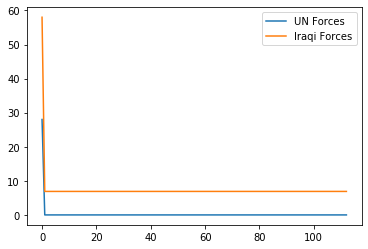

In [1484]:
t = range(0,T_MAX + 1)
plt.plot(t, track_un, label="UN Forces")
plt.plot(t, track_iraqi, label="Iraqi Forces")
plt.legend()
plt.show()

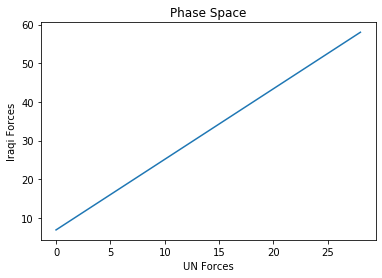

In [1485]:
plt.plot(track_un, track_iraqi)
plt.title("Phase Space")
plt.xlabel("UN Forces")
plt.ylabel("Iraqi Forces")
plt.show()

### Result Analysis

These are certainly interesting results! According to the predictions Lanchester's Law made from our parameters, the Iraqi forces should have won within the first 24 seconds of the battle while suffering heavy losses. We know this disagrees with what happened in reality, but why so? We first examine what the required number of UN forces are required to turn the tide of battle. The follow snippet has been written for you to run through the impact of changing the number of M1A1 tanks.

In [1486]:
strength = range(123, 1000, 10)
rem_un = []
rem_iraqi = []
phase_un = []
phase_iraqi = []
for x in strength:
    blue = UN(x)
    red = Iraqi(265)
    track_un, track_iraqi = sim(F, blue, red, T_MAX)
    rem_un.append(track_un[-1])
    rem_iraqi.append(track_iraqi[-1])
    phase_un.append(track_un)
    phase_iraqi.append(track_iraqi)

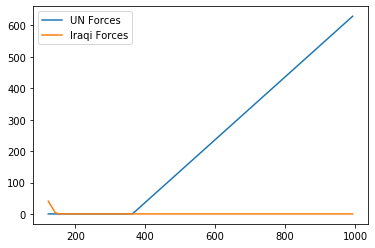

In [1487]:
plt.plot(strength, rem_un, label="UN Forces")
plt.plot(strength, rem_iraqi, label="Iraqi Forces")
plt.legend()
plt.show()

In [1510]:
# Optional phase space diagram can be seen here. However, it has little analytical value as it is not cyclical.
# for i,phase in enumerate(zip(phase_un[0::10], phase_iraqi[0::10])):
#     plt.plot(phase[0], phase[1], label=i)
# plt.title("Phase Space")
# plt.xlabel("UN Forces")
# plt.ylabel("Iraqi Forces")
# plt.legend()
# plt.show()

It seems that the UN required ~400 tanks, or about 1400% more tanks to win the battle. Now, do the same as above, but changing the probability of hit of the UN forces from 0.78 to 1.

In [1489]:
# Vary the the probability of hit and observe its impact on the battle
# Look at the constructor of the forces to change the probability of hit
hit = np.arange(0.78, 1, 0.01)
rem_un = []
rem_iraqi = []
for p in hit:
    blue = UN(123,hit=p)
    red = Iraqi(265)
    track_un, track_iraqi = sim(F, blue, red, T_MAX)
    rem_un.append(track_un[-1])
    rem_iraqi.append(track_iraqi[-1])

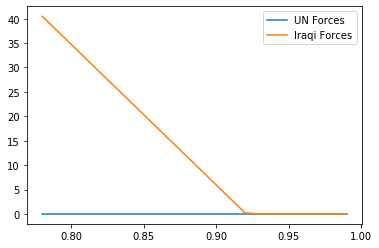

In [1490]:
plt.plot(hit, rem_un, label="UN Forces")
plt.plot(hit, rem_iraqi, label="Iraqi Forces")
plt.legend()
plt.show()

It seems that the UN can never win! Only bring down their enemies together with them.

### Evaluating the Continuous Time Model
Different parameters can be easily varied as with the above two examples. However, the trend seems to be that the Iraqi forces inevitably win the battle. Furtheremore, by varying each parameter we show that the UN forces need to improve their strength by a large proportion before even coming close to surviving the battle. There are two possible explanations for this phenomenon, one could be that the UN forces got incredibly lucky to the point that they could defy statistics, the other being that the model is not comprehensive and thus not accurate.

A qualitative look of Lanchester’s Model reveals several key weaknesses that might not have been apparent in the era when it was first conceived. Firstly, the forces are all aggregated today as it was assumed that multiple units can target the same enemy, and the overall effect is that each enemy is attacked en masse. However, given the improvements in radio technology since 1916, ally units can now communicate effectively so they do not have to attack the same unit simultaneously. This limits the number of lopsided conflicts that you find in a simple infantry firefight, where fire is concentrated by the entire platoon on only one enemy at a time. 

Secondly, Lanchester’s Model measure of force effectiveness is a direct reflection of a unit’s firepower and assumes that overwhelming force will win you the battle. However, this ignores the probability of detecting the enemy in the first place, especially in a tank battle where enemies are kilometres apart. We cannot simply integrate this probability into the force effectiveness as an enemy need to be detected only once. Thus, such a simulation requires a stateful representation, such as in a Markov Chain Model.

## Markov Chain Model

A Markov Chain Model is simply a sequence of states, with the next state determined stochastically based only on the current state. Before we can construct such a model, we must first identify the states a tank can be in. For this model, we use the following states:

1. Scout
2. Engaged
3. Hit
4. Enemy Killed

A tank is first in the "Scout" state, looking out for possible enemies, with a probability of detecting an enemy proportional its range of detection. Upon detecting an enemy, it enters the "Engaged" state and fires a shell at the enemy. The shell has a probability of hitting the enemy, upon which it will proceed to the "Hit" stage, else, it will stay in the "Engaged" state. At the "Hit" stage, it will have the probability of killing the enemy upon which it will enter the "Enemy Killed" state, else it will again enter the "Engaged" state. At the "Enemy Killed" state, one tank of the opposite force is removed. After the "Enemy Killed" state, it will enter the "Scout" stage, representing how the unit is seeking for a new target after destroying the previous one. As each step of the simulation represents a fixed step size, we will keep track of the time consumed as we run through the Markov Chain, until $t = step\_size$. This is done at state "Engaged" which advances time by $\frac{1}{r_{fire}}$, representing the rate of fire for the tank. At the "Enemy Killed" state, time will advance by $rand(0,step\_size)$, representing the stochasticity in detecting the next enemy. This is better illustrated by the diagram below.

<img src = "markov_diag.jpg" width="450px">
<center>Figure 2. Markov Chain State Diagram</center>


### Additional Assumptions
In addition to the general assumptions we had made for all models, there are additional assumptions unique to the Markov Chain Model

1. Enemies are killed at random, as there is no targeting mechanism and each chain is independent
2. The higher the range of detection, the higher the probability of detecing an enemy

### Building the Markov Chain
We start by building the transition matrix for each tank. Fill in the required parameters below

In [1491]:
# Build the transition matrix for each tank by filling up the transition probabilities
trans_M1A1 = {}
trans_M1A1["SCOUT"] = {"ENGAGED": M1A1_RANGE / 10000, "SCOUT": 1 - (M1A1_RANGE / 10000)}
trans_M1A1["ENGAGED"] = {"HIT": M1A1_HIT, "ENGAGED": 1- M1A1_HIT}
trans_M1A1["HIT"] =  {"KILL": M1A1_KILL, "ENGAGED": 1 - M1A1_KILL}
trans_M1A1["KILL"] = {"SCOUT": 1}

trans_T62 = {}
trans_T62["SCOUT"] = {"ENGAGED": T62_RANGE / 10000, "SCOUT": 1 - (T62_RANGE / 10000)}
trans_T62["ENGAGED"] = {"HIT": T62_HIT, "ENGAGED": 1- T62_HIT}
trans_T62["HIT"] =  {"KILL": T62_KILL, "ENGAGED": 1 - T62_KILL}
trans_T62["KILL"] = {"SCOUT": 1}

We now need to define an individual tank object to keep track of the model and the current time its at

In [1512]:
class Unit:
    
    def __init__(self, model):
        self.state = "SCOUT"
        if model == "M1A1":
            self.trans = trans_M1A1
            self.reload = 1 / M1A1_RATE
        else:
            self.trans = trans_T62
            self.reload = 1 / T62_RATE

Now we can set up the main loop to run through our chain for each timestep. Fill in the state dependent time update algorithm and update the number of tanks left each time one is killed.

In [1514]:
def markov_step(tanks):
    killed = 0
    for tank in tanks:
        t = 0
        while t < step_size:
            p = random.random()
            curr_p = 0
            next_state = ""
            for state, p_state in tank.trans[tank.state].items():
                curr_p = curr_p + p_state
                if curr_p > p:
                    next_state = state
                    break
            tank.state = next_state
            # Fill in the required state dependent algorithms here
            if tank.state == "ENGAGED":                
                t = t + tank.reload
            if tank.state == "KILL":
                t = t + random.random()
                killed = killed + 1
    return killed

In [1517]:
def markov(blue, red, t_max):
    track_un = [len(blue)]
    track_iraqi = [len(red)]
    for i in range(t_max):
        T62_dead = markov_step(blue)
        M1A1_dead = markov_step(red)
        if M1A1_dead is not 0:
            blue = blue[:-M1A1_dead]
        if T62_dead is not 0:
            red = red[:-T62_dead]
        track_un.append(len(blue)) 
        track_iraqi.append(len(red))
    return track_un, track_iraqi

### Running the Model
Set up the required units and timeframe, then run the model for the duration of the battle

In [1518]:
# Create the required forces and set the time duration then run the model
blue = []
for i in range(M1A1_N):
    blue.append(Unit("M1A1"))
red = []
for i in range(T62_N):
    red.append(Unit("T62"))
track_un, track_iraqi = markov(blue, red, T_MAX)

### Results
Similar to the Continuous Time Model, we obtain plot the number of surviving tanks against time

In [1519]:
print(track_un)
print(track_iraqi)

[28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[58, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]


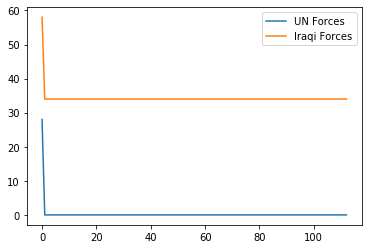

In [1520]:
t = range(0,T_MAX + 1)
plt.plot(t, track_un, label="UN Forces")
plt.plot(t, track_iraqi, label="Iraqi Forces")
plt.legend()
plt.show()

In [1521]:
# Optional phase space diagram can be seen here. However, it has little analytical value.
# plt.plot(track_un, track_iraqi)
# plt.title("Phase Space")
# plt.xlabel("UN Forces")
# plt.ylabel("Iraqi Forces")
# plt.show()

### Result Analysis
Again, these results suggest a crushing defeat of the UN forces at the hands of the Iraqi troops and it seems that the new variables and states brought into play are not enough to replicate what had happened in reality. As with the previous model, we can now try to predict what the model would suggest the minimum strength of the UN forces be in order to win the battle. As with what you had done for the Continuous Time Model, vary the strength of the UN forces and run the Markov Chain Model for each value.

In [1499]:
# Fill in the required algorithm here
strength = range(123, 1000, 10)
rem_un = []
rem_iraqi = []
phase_un = []
phase_iraqi = []
for x in strength:
    blue = []
    for i in range(M1A1_N):
        blue.append(Unit("M1A1"))
    red = []
    for i in range(T62_N):
        red.append(Unit("T62"))
    track_un, track_iraqi = markov(blue, red, T_MAX)
    rem_un.append(track_un[-1])
    rem_iraqi.append(track_iraqi[-1])
    phase_un.append(track_un)
    phase_iraqi.append(track_iraqi)

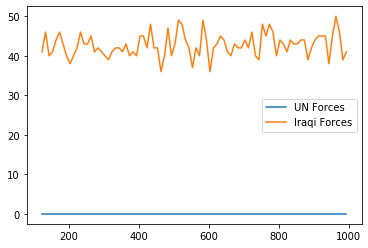

In [1500]:
plt.plot(strength, rem_un, label="UN Forces")
plt.plot(strength, rem_iraqi, label="Iraqi Forces")
plt.legend()
plt.show()

In [1522]:
# Optional phase space diagram can be seen here. However, it has little analytical value as it is not cyclical.
# for i,phase in enumerate(zip(phase_un[0::10], phase_iraqi[0::10])):
#     plt.plot(phase[0], phase[1], label=i)
# plt.title("Phase Space")
# plt.xlabel("UN Forces")
# plt.ylabel("Iraqi Forces")
# plt.legend()
# plt.show()

Under the Markov Chain Model, it seems that the UN forces absolutely no way of winning the battle, even with significantly more tanks. Do run the model a few times to observe the stochastic nature of a Markov Chain Model as opposed to a Continuous Time Model.

### Evaluating the Markov Chain Model
It seems even including more aspects of the battle is unable to change the results of the model, in fact the predictions suggested by the model indicate that the win by the UN forces was a complete fluke. However, before we come to such a conclusion, we have one more element to improve on, the terrain. Since ancient times the spatiality of any battle plays a critical role in determining the winner of the battle, with even Sun Tzu declaring that “the natural formation of the country is the soldier's best ally”. That certainly has not changed in a modern battle and we will try to incorporate this spatiality into our simulation by looking to an Agent Based Model.

## Agent Based Model
An Agent Based Model [7] inherently incorporates a larger variety of factors as compared to previous two approaches and its focus on low level, individual movements only produces a consistent result if a strong self-emergent property is present. For this model, we will be modelling units as its own type of agent with its own unique set of parameters and are placed in points on the map replicating the real battle. This represents the UN forces attacking the stationed Iraqi forces at 73 Easting from the East, as in the actual battle.

First, define a utility function that determines the distance between two agents

In [1502]:
def distance(a, b):
    # Return the distance between two points
    return ((a.x - b.x)**2 + (a.y - b.y)**2)**0.5

We can now start building the individual control logic for the agents. The two models of tanks have effectively the same control logic, but implemented with different parameters. For this battle, the control logic is relatively simple, the tanks advance towards each other, until an enemy is within the range of detection, upon which the tank will fire. A successful hit and kill will remove the enemy tank at the end of the step. The tank cannot fire while moving. You may assume that the tanks know when all enemies have been destroyed.

The constructor and function headers have been implmented for you.

In [1558]:
class agent_UN:
    
    def __init__(self, x, y, v=M1A1_V, hit=M1A1_HIT, kill=M1A1_KILL, r=M1A1_RATE, rng=M1A1_RANGE):
        # Parameters for each UN tank
        self.x = x
        self.y = y
        self.v = ((1000 * v) / 60) * step_size # velocity in meters per stepsize
        self.hit = hit # probability of hit
        self.kill = kill # probability of kill
        self.r = r * step_size # shots per minute
        self.rng = rng # range of detection
        # Uncomment the line below to install optical sights on the tanks instead of thermal sights
        # self.rng = T62_RANGE 
        self.dead = False
        
    def step(self, enemies):
        # Write your code for the main step logic here
        fired = False
        for shot in range(math.floor(self.r)):
            for enemy in enemies:
                targets = []
                if distance(self, enemy) <= self.rng:
                    targets.append(enemy)
                if len(targets) > 0:
                    self.fire(targets[0])
                    fired = True
        if fired == False and len(enemies) > 0:
            self.move()
            
    def move(self):
        # Write your code for the move logic here
        if self.x < 67500:
            self.x = self.x + self.v
        
    def fire(self, enemy):
        # Write your code for the fire logic here
        p_hit = random.random()
        if p_hit < self.hit:
            p_kill = random.random()
            if p_kill < self.kill:
                enemy.dead = True

class agent_Iraqi:
    
    def __init__(self, x, y, v=T62_V, hit=T62_HIT, kill=T62_KILL, r=T62_RATE, rng=T62_RANGE):
        # Parameters for each Iraqi tank       
        self.x = x
        self.y = y
        self.v = ((1000 * v) / 60) * step_size # velocity in meters per stepsize
        self.hit = hit # probability of hit
        self.kill = kill # probability of kill
        self.r = r * step_size # shots per minute
        self.rng = rng # range of detection
        self.dead = False
        
    def step(self, enemies):
        # Write your code for the main step logic here
        fired = False
        for shot in range(math.floor(self.r)):
            for enemy in enemies:
                targets = []
                if distance(self, enemy) <= self.rng:
                    targets.append(enemy)
                if len(targets) > 0:
                    self.fire(targets[0])
                    fired = True
        if fired == False and len(enemies) > 0:
            self.move()

            
    def move(self):
        # Write your code for the move logic here
        if self.x > 67500:
            self.x = self.x - self.v
        
    def fire(self, enemy):
        # Write your code for the fire logic here
        p_hit = random.random()
        if p_hit < self.hit:
            p_kill = random.random()
            if p_kill < self.kill:
                enemy.dead = True

With the individual control logic sorted, this loop will run the Agent Based Model for t_max steps and plots a graph at every specified interval.

In [1559]:
def abm(blue, red, t_max, plot=15):
    track_un = [len(blue)]
    track_iraqi = [len(red)]
    for t in range(t_max):
        for tank in blue:
            tank.step(red)
            if t % plot == 0:
                plt.plot(tank.x, tank.y, "bo") 
        for tank in red:
            tank.step(blue)
            if t % plot == 0:
                plt.plot(tank.x, tank.y, "C1x") 
        if t % plot == 0 and len(blue) > 0 and len(red) > 0:        
            plt.axis([55000, 80000, 0, 25000])
            plt.title("Battlefield at Time " + str(t))
            plt.show()
        nu_blue = []
        nu_red = []
        for tank in blue:
            if not tank.dead:
                nu_blue.append(tank)
        for tank in red:
            if not tank.dead:
                nu_red.append(tank)
        blue = nu_blue
        red = nu_red
        track_un.append(len(blue)) 
        track_iraqi.append(len(red))
    return track_un, track_iraqi

Now, create the forces and run the model for T_MAX steps.

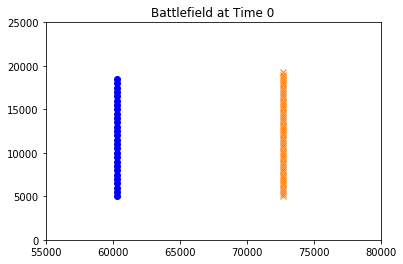

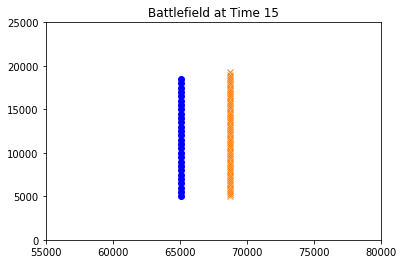

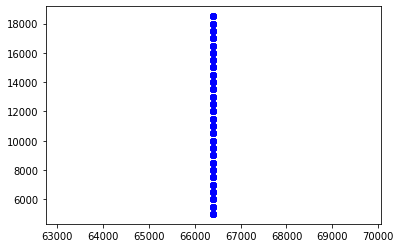

In [1565]:
blue = []
for i in range(M1A1_N):
    blue.append(agent_UN(60000,(500 * i) + 5000))
red = []
for i in range(T62_N):
    red.append(agent_Iraqi(73000, (250 * i) + 5000))
track_un, track_iraqi = abm(blue, red, T_MAX)

In [1566]:
print(track_un)
print(track_iraqi)

[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28]
[58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


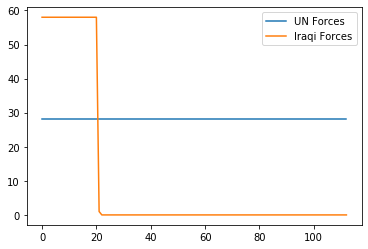

In [1564]:
t = range(0,T_MAX + 1)
plt.plot(t, track_un, label="UN Forces")
plt.plot(t, track_iraqi, label="Iraqi Forces")
plt.legend()
plt.show()

Now this looks like the result that we see in the real battle!

### Evaluating the Agent Based Model
The Agent Based Model clearly reflects what had happened in reality, a clear decimation of the Iraqi forces by the UN forces will sustaining no casualties of their own. From the map of the area, we can see that what allowed the UN forces such a decisive victory was their significant advantage in the radius of detection. During the battle, the weather was absolutely terrible with visibility being really low due to heavy rains and sand storms. The Iraqi tanks, equipped with only an optical sight could only see around 200 meters. The UN forces however, were equipped with thermal sights that worked well even in such adverse weather, and was ultimately what gave them the edge in winning the battle. You can observe this for yourself by uncommenting the line indicated to install optical sights into the M1A1 tanks. This will cause a complete reversal of the battle and the Iraqi forces will decimate the UN forces insted.

## Conclusion
Having been through 3 different models with the same input parameters, we can clearly see that the Agent Based Model replicates the actual battle the most accurately. Coupled with the fact that the Agent Based Model accounts for the largest number of factors, it can be concluded that the UN forces' absolute victory at the Battle of 73 Easting was not a fluke. This form of simulation is not new, and varients of it have long been conducted by various military agencies as they see it as the gold standard of reproducing military battles.

Furthermore, through building these 3 models, you would have hopefully seen how a modular and extensibly built model makes further adjustment easy to conduct. This allows for "what if" situations to be played out easily and policy planners can use these as a tool to better understand the impacts of their actions.

## REFERENCES
[1]Mark Anderson. 2013.  Agent-Based Modelling in the New Zealand DefenceForce. <br/>
[2]Wikimedia Commons. 1991. Type 69 Operation Desert Storm. https://commons.wikimedia.org/wiki/File:Type_69_Operation_Desert_Storm.jpg <br/>
[3]Raymond R. Hill and J. O. Miller. 2017. A History Of United States Military Simu-lation. InProceedings of the 2017 Winter Simulation Conference, G. Zacharewicz N.Mustafee G. Wainer W. K. V. Chan, A. D’Ambrogio and E. Page (Eds.). Department of Operational Sciences, Air Force Institute of Technology. <br/>
[4]Jan Jelinek. 2001. Predictive models of battle dynamics. Proceedings of SPIE4367,1, 351–364.<br/>
[5]Dominic D.P Johnson and Niall J Mackay. 2015. Fight the power: Lanchester’slaws of combat in human evolution. Evolution and Human Behavior 36, 2(2015), 152–163. <br/>
[6]F. W Lanchester. 1916. Aircraft in warfare: the dawn of the fourth arm. Constableand company limited,  http://hdl.handle.net/2027/uc1.%24b51071 <br/>
[7]Jaeyeong Lee, Sunwoo Shin, Moonsung Park, and Chongman Kim. 2018. Agent-Based  Simulation and Its  Application to Analyze Combat Effectiveness in Network-Centric Warfare Considering Communication Failure Environments. Mathematical Problems in Engineering 2018 (2018).<br/>
[8]John W. R. Lepingwell. 1987. The Laws of Combat? Lanchester Reexamined.International Security12, 1 (1987), 89–134.<br/>
[9]Thomas W. Lucas and Turker Turkes. 2004. Fitting Lanchester equations tothe battles of Kursk and Ardennes. Naval Research Logistics (NRL)51, 1(2004), 95–116.<br/>
[10]Logan Nye. 2016. The story of ‘the last great tank battle’ where the US destroyed30 Iraqi tanks.Business Insider(Feb. 2016).  https://www.businessinsider.com/the-last-great-tank-battle-where-the-us-destroyed-30-iraqi-tanks-2016-2<br/>
[11]Jesse Orlansky and Jack Thorpe (Eds.). 1991.73 EASTING: Lessons Learned FromDesert Storm via Advanced Distributed Simulation Technology. Institute for Defense Analyses.<br/>
[12]Michael Pearson. [n.d.]. Gaming the Future. ([n.d.]). https://www.iac.gatech.edu/news-events/features/path-gaming-and-simulation-courses<br/>
[13]Laura Spear and Vincent Baines. 2009. An Initial Conceptual Model for Morale Factors. In Proceedings of the 18th Conference on Behavior Representation in Modeling and Simulation.<br/>
[14]Hiroki Syama. 2015.Continuous-Time Models: Modeling. Open SUNY Textbooks,Chapter 6.<br/>
[15]Anthony Tucker-Jones. 2014.Desert Sabre. Pen Sword Military, Chapter 7,77–88.<br/>
[16]W. M. Christenson and Robert A. Zirkle. 1992. 73 Easting Battle Replication – A Janus Combat Simulation. (Sep 1992). <br />
[17]John Mann, David Fisher, Matt Kraus, Erik Lowndes, and Allen York. 2006. Ananalysis of engagement algorithms for real-time weap<br />
[18]Iron Drapes. 2015. T-62.https://thesovietarmourblog.blogspot.com/2015/12/t-62.html#cannon

## Division of Labor

<b>Chuyun Sun:</b> Formulate and implement the ContinuousTime Model; Evaluate the Continuous Time Model and analysis the result; write the notebook <br />
<b>Youyi Shi:</b> Formulate and implement the Markov Chain Model; Evaluate the Markov Chain Model and analysis the result; write the notebook <br />
<b>Yong Jian Quek:</b> Formulate and implement the Agent-Based Model; Evaluate the Agent-Based Model and analysis the result; write the notebook and introductory material <br />